# **Insincere Question Classification**

An existential problem for any major website today is how to handle toxic and divisive content. Quora wants to tackle this problem head-on to keep their platform a place where users can feel safe sharing their knowledge with the world.
Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.
In this competition, Kagglers will develop models that identify and flag insincere questions. To date, Quora has employed both machine learning and manual review to address this problem. With your help, they can develop more scalable methods to detect toxic and misleading content.
Here's your chance to combat online trolls at scale. Help Quora uphold their policy of “Be Nice, Be Respectful” and continue to be a place for sharing and growing the world’s knowledge.

For each qid in the test set, you must predict whether the corresponding question_text is insincere (1) or not (0). Predictions should only be the integers 0 or 1. The file should contain a header and have the following format:

```
qid, prediction
0000163e3ea7c7a74cd7,0
00002bd4fb5d505b9161,0
00007756b4a147d2b0b3,0
```

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

Has a non-neutral tone 
*   Has an exaggerated tone to underscore a point about a group of people
*   Is rhetorical and meant to imply a statement about a group of people

Is disparaging or inflammatory 
*   Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
*   Makes disparaging attacks/insults against a specific person or group of people 
*   Based on an outlandish premise about a group of people 
*   Disparages against a characteristic that is not fixable and not measurable

Isn't grounded in reality 
*   Based on false information, or contains absurd assumptions
*   Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers
*   The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.

**Files description**

train.csv - the training set

test.csv - the test set

sample_submission.csv - A sample submission in the correct format

enbeddings/ - (see below)

**Data Field** 

qid - unique question identifier

question_text - Quora question text

target - a question labeled "insincere" has a value of 1, otherwise 0

## Data importation

Below we import the data from Google Drive, this step requires a connection to a google drive containing the files. 

In [0]:
# How to import the data stored in drive:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials
from sklearn import model_selection
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import random as rd
import time
import torch as th
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive_pers = GoogleDrive(gauth)

# Extraction of train data
link_train = 'https://drive.google.com/open?id=15fKt75l3ifY-v_VuGfQ2t9gLtLpobDqy' 
id_train = link_train.split('=')[-1]
downloaded = drive_pers.CreateFile({'id':id_train}) 
downloaded.GetContentFile('train.csv')  
df_train = pd.read_csv('train.csv')
print("Train data:")
print(df_train)
print()

# Extraction of test data
link_test = 'https://drive.google.com/open?id=1JFqNLXe8evmCF9KULkRPqjJJa-bf7iAc'
id_test = link_test.split('=')[-1]
downloaded = drive_pers.CreateFile({'id':id_test}) 
downloaded.GetContentFile('test.csv')  
test_df = pd.read_csv('test.csv')
print("Test data:")
print(test_df)

train_df, validate_df = model_selection.train_test_split(df_train, test_size=0.1)
del(df_train)

Train data:
                          qid  ... target
0        00002165364db923c7e6  ...      0
1        000032939017120e6e44  ...      0
2        0000412ca6e4628ce2cf  ...      0
3        000042bf85aa498cd78e  ...      0
4        0000455dfa3e01eae3af  ...      0
...                       ...  ...    ...
1306117  ffffcc4e2331aaf1e41e  ...      0
1306118  ffffd431801e5a2f4861  ...      0
1306119  ffffd48fb36b63db010c  ...      0
1306120  ffffec519fa37cf60c78  ...      0
1306121  ffffed09fedb5088744a  ...      0

[1306122 rows x 3 columns]

Test data:
                         qid                                      question_text
0       0000163e3ea7c7a74cd7  Why do so many women become so rude and arroga...
1       00002bd4fb5d505b9161  When should I apply for RV college of engineer...
2       00007756b4a147d2b0b3  What is it really like to be a nurse practitio...
3       000086e4b7e1c7146103                             Who are entrepreneurs?
4       0000c4c3fbe8785a3090   Is education 

In [0]:
print(train_df.values[0])
print(test_df.values[0])

['6c4d8021d53467487e69'
 'What can be the explanation of "the blue danube" by Johann Strauss?' 0]
['0000163e3ea7c7a74cd7'
 'Why do so many women become so rude and arrogant when they get just a little bit of wealth and power?']


## Embeddings

We have to turn this string sentence into something that could be an input for our Neural Network: a vector.
For this, the Kaggle website suggests different embeddings: word2vec, Glove, wikinews. 


### Glove
Let's start with **Glove** (+ than 2M words, embeddings vectors of dimension 300, description [here](https://nlp.stanford.edu/projects/glove/)):

*The following code, doesn't work on colab, it is just here as an appendix*

In [0]:
def create_dict_glove():
  '''
  Creates dictionary by importing data from the glove.840B.300d.txt file. This 
  function is created especially for this file. 
  OUTPUT:
  - words_dict : dictionary key = string of the word, value = array of the embeddings
  corresponding to this word.
  RUNNING TIME:
  Very long: around 10 minutes to import the whole file.
  '''
  words_dict = {}
#   # Extraction of embeddings dictionnary
#   link_dict = "https://drive.google.com/open?id=14HSnOa4OnH2J-unsFwBOGJQjzE1pk7nO"
#   id_dict = link_dict.split('=')[-1]
#   downloaded = drive_pers.CreateFile({'id':id_dict}) 
#   downloaded.GetContentFile('glove.840B.300d.txt')  
  f = open('glove.840B.300d.txt', 'r', encoding='utf8')
  for line in tqdm(f):
    # try:
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    words_dict[word] = coefs
    # except:
      # print(f.readline())
      # continue
  f.close()
  return words_dict

# words_dict = create_dict_glove()
# np.save( "words_dict_glove.npy", words_dict, allow_pickle = True)

We import the dictionary with numpy.load to go faster.

In [0]:
if 'words_dict' not in globals():
  # The dictionnary is already created in the drive:
  link_dict = 'https://drive.google.com/open?id=1y2r7uB2HfO_it50EJfYJtAJqAs-4zqqO'
  id_dict = link_dict.split('=')[-1]
  downloaded = drive_pers.CreateFile({'id':id_dict}) 
  downloaded.GetContentFile('words_dict_glove.npy')  
  words_dict = np.load('words_dict_glove.npy', allow_pickle = True).item()
  words_dict[" "] = np.zeros(300, dtype=np.float32)

In [0]:
#print(len(words_dict))

### Wiki-News
We can also try to use the **Wiki_news** embedding (1 million words vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).) 

As a comparision, Oxford dictionnary contains 171,476 words.

*The following code cannot be executed on colab, it is here just an appendix.*

In [0]:
def create_dict_wiki(file_name):
  '''
  Creates dictionary by importing data from the wiki-news-300d-1M.vec file. This 
  function is created especially for this file. 
  INPUT:
  - file_name : string of the path where we can find the wiki-news file
  OUTPUT:
  - my_dict : dictionary key = string of the word, value = array of the embeddings
  corresponding to this word.
  RUNNING TIME:
  Very long: around 10 minutes to import the whole file.
  '''
  my_file = open(file_name,'r', encoding="utf8")
  print("Extracting dictionnary from 'wiki-news-300d-1M.vec' file...")
  nb_lines = eval(my_file.readline().split(' ')[0])
  my_dict = {}
  for i in range(nb_lines):
    if (i%50000==0): print('{:>7}'.format(i), '|', '{:<7}'.format(nb_lines))
    line = my_file.readline()
    list_elem = line.split(" ")
    key = list_elem[0]
    value = []
    list_elem = list_elem[1:]
    for elem in list_elem:
      elem = eval(elem)
      value.append(elem)
    my_dict[key] = np.array(value, dtype=np.float16)
  print("Extraction finished.")  
  my_file.close()
  return my_dict

# words_dict = create_dict_wiki('/content/drive/My Drive/Cours/Kaggle/wiki-news-300d-1M.vec')
# np.save( "words_dict.npy", words_dict, allow_pickle = True)

In [0]:
#if 'words_dict' not in globals():
#  # The dictionnary is already created in the drive:
#  link_dict = 'https://drive.google.com/open?id=1k_uAS5IWudMPhJF6WzdLAEIlZsD0FVDG'
#  id_dict = link_dict.split('=')[-1]
#  downloaded = drive_pers.CreateFile({'id':id_dict}) 
#  downloaded.GetContentFile('words_dict_wiki.npy')  
#  words_dict = np.load('words_dict_wiki.npy', allow_pickle = True).item()
#  words_dict[" "] = np.zeros(300, dtype=np.float32)

### Word2vec
We can also use **word2vec**. (The following code is taken from Kaggle topic section).

In [0]:
#from gensim.models import KeyedVectors

#news_path = '/content/drive/My Drive/Cours/Kaggle/GoogleNews-vectors-negative300.bin'
#embeddings_index = KeyedVectors.load_word2vec_format(news_path, binary=True)
#print(type(embeddings_index))
#words_dict = {}
#for word in embeddings_index.vocab:
#  words_dict[word] = embeddings_index[word]
#np.save("words_dict.npy", words_dict, allow_pickle=True)

In [0]:
#if 'words_dict' not in globals():
#  # The dictionnary is already created in the drive:
#  link_dict = 'https://drive.google.com/open?id=1GcEcGNODNQmuh3bdDFI8vXiCnLHR-Oib'
#  id_dict = link_dict.split('=')[-1]
#  downloaded = drive_pers.CreateFile({'id':id_dict}) 
#  downloaded.GetContentFile('words_dict_google.npy')  
#  words_dict = np.load('words_dict_google.npy', allow_pickle = True).item()
#  words_dict[" "] = np.zeros(300, dtype=np.float32)

## Text normalization

We have developped a function that transform the text a little so that it is 
easier to exploit. It merely isolates unusual characters. 

In [0]:
dict_replace = {"€": "euros", 
"$": "dollar", 
"£": "pound", 
"aren't": "are not", 
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not", 
"don't" : "do not", 
"hadn't" : "had not", 
"hasn't" : "has not", 
"haven't" : "have not", 
"he'd" : "he would", 
"he'll" : "he will", 
"he's" : "he is", 
"i'd" : "I would", 
"i'll" : "I will", 
"i'm" : "I am", 
"isn't" : "is not", 
"it's" : "it is", 
"it'll": "it will", 
"i've" : "I have", 
"let's" : "let us", 
"mightn't" : "might not", 
"mustn't" : "must not", 
"shan't" : "shall not", 
"she'd" : "she would", 
"she'll" : "she will", 
"she's" : "she is", 
"shouldn't" : "should not",
"that's" : "that is", 
"there's" : "there is", 
"they'd" : "they would", 
"they'll" : "they will", 
"they're" : "they are", 
"they've" : "they have", 
"we'd" : "we would", 
"we're" : "we are", 
"weren't" : "were not", 
"we've" : "we have", 
"what'll" : "what will", 
"what're" : "what are", 
"what's" : "what is", 
"what've" : "what have", 
"where's" : "where is", 
"who'd" : "who would", 
"who'll" : "who will", 
"who're" : "who are", 
"who's" : "who is", 
"who've" : "who have", 
"won't" : "will not", 
"wouldn't" : "would not", 
"you'd" : "you would", 
"you'll" : "you will", 
"you're" : "you are", 
"you've" : "you have", 
"'re" : " are", 
"wasn't" : "was not", 
"we'll" : "will", 
"didn't" : "did not", 
"tryin'" : "trying", 
"gey" : "gay", 
"fck" : "fuck", 
"gayyy" :"gay", 
"mem" : "mother", 
"dont" :"do not", 
"wont" : "would not", 
"cant" : "could not",
'colour' : 'color',
'centre' : 'center',
'favourite' : 'favorite', 
'travelling' : 'traveling', 
'counselling' : 'counseling', 
'theatre' : 'theater', 
'cancelled' : 'canceled', 
'labour' : 'labor', 
'organisation' : 'organization',
'wwii' : 'world war 2',
'citicise' : 'criticize',
'youtu ' : 'youtube',
'yt': 'youtube',
'fb': 'facebook', 
'Qoura' : 'Quora',
'sallary' : 'salary',
'Whta' : 'What',
'narcisist' : 'narcissist',
'howdo' : 'how do',
'whatare' : 'what are',
'howcan' : 'how can',
'howmuch' : 'how much',
'howmany' : 'how many',
'whydo' : 'why do',
'doI' : 'do I',
'theBest' : 'the best',
'howdoes' : 'how does',
'mastrubation' : 'masturbation',
'mastrubate' : 'masturbate',
"mastrubating" : 'masturbating',
'pennis' : 'penis',
'Etherium' : 'Ethereum',
'narcissit' : 'narcissist',
'bigdata' : 'big data',
'2k17' : '2017',
'2k18' : '2018',
'qouta': 'quota',
'exboyfriend' : 'ex boyfriend',
'airhostess' : 'air hostess',
"whst" : 'what',
'watsapp' : 'whatsapp',
'demonitisation' : 'demonetization',
'demonitization' : 'demonetization',
'demonetisation' : 'demonetization',
"f*ck" : "fuck",
"f**k" : "fuck",
"fuuck" : "fuck",
"d*ck" : "dick",
"c*ck" : "cock",
"b*tch" : "bitch",
"b**ch" : "bitch",
"sh*t" : "shit",
"d*ckhead" : "dickhead"
}

contraction_mapping = {"ain't": "is not", 
                       "aren't": "are not",
                       "can't": "cannot", 
                       "'cause": "because", 
                       "could've": "could have", 
                       "couldn't": "could not", 
                       "didn't": "did not",  
                       "doesn't": "does not", 
                       "don't": "do not", 
                       "hadn't": "had not", 
                       "hasn't": "has not", 
                       "haven't": "have not",
                       "he'd": "he would",
                       "he'll": "he will", 
                       "he's": "he is", 
                       "how'd": "how did",
                       "how'd'y": "how do you", 
                       "how'll": "how will", 
                       "how's": "how is",  
                       "I'd": "I would", 
                       "I'd've": "I would have",
                       "I'll": "I will", 
                       "I'll've": "I will have",
                       "I'm": "I am", 
                       "I've": "I have", 
                       "i'd": "i would",
                       "i'd've": "i would have",
                       "i'll": "i will", 
                       "i'll've": "i will have",
                       "i'm": "i am", 
                       "i've": "i have", 
                       "isn't": "is not", 
                       "it'd": "it would",
                       "it'd've": "it would have", 
                       "it'll": "it will",
                       "it'll've": "it will have",
                       "it's": "it is",
                       "let's": "let us",
                       "ma'am": "madam",
                       "mayn't": "may not",
                       "might've": "might have",
                       "mightn't": "might not",
                       "mightn't've": "might not have",
                       "must've": "must have",
                       "mustn't": "must not",
                       "mustn't've": "must not have",
                       "needn't": "need not",
                       "needn't've": "need not have",
                       "o'clock": "of the clock",
                       "oughtn't": "ought not",
                       "oughtn't've": "ought not have",
                       "shan't": "shall not",
                       "sha'n't": "shall not",
                       "shan't've": "shall not have",
                       "she'd": "she would",
                       "she'd've": "she would have", 
                       "she'll": "she will",
                       "she'll've": "she will have",
                       "she's": "she is",
                       "should've": "should have",
                       "shouldn't": "should not",
                       "shouldn't've": "should not have",
                       "so've": "so have",
                       "so's": "so as",
                       "this's": "this is",
                       "that'd": "that would",
                       "that'd've": "that would have", 
                       "that's": "that is",
                       "there'd": "there would",
                       "there'd've": "there would have",
                       "there's": "there is", 
                       "here's": "here is",
                       "they'd": "they would",
                       "they'd've": "they would have", 
                       "they'll": "they will", 
                       "they'll've": "they will have", 
                       "they're": "they are", 
                       "they've": "they have", 
                       "to've": "to have", 
                       "wasn't": "was not", 
                       "we'd": "we would",
                       "we'd've": "we would have",
                       "we'll": "we will",
                       "we'll've": "we will have", 
                       "we're": "we are", 
                       "we've": "we have", 
                       "weren't": "were not", 
                       "what'll": "what will", 
                       "what'll've": "what will have", 
                       "what're": "what are",  
                       "what's": "what is", 
                       "what've": "what have", 
                       "when's": "when is", 
                       "when've": "when have", 
                       "where'd": "where did", 
                       "where's": "where is", 
                       "where've": "where have", 
                       "who'll": "who will", 
                       "who'll've": "who will have", 
                       "who's": "who is", 
                       "who've": "who have", 
                       "why's": "why is", 
                       "why've": "why have", 
                       "will've": "will have",
                       "won't": "will not", 
                       "won't've": "will not have",
                       "would've": "would have",
                       "wouldn't": "would not",
                       "wouldn't've": "would not have",
                       "y'all": "you all", 
                       "y'all'd": "you all would",
                       "y'all'd've": "you all would have",
                       "y'all're": "you all are",
                       "y'all've": "you all have",
                       "you'd": "you would", 
                       "you'd've": "you would have",
                       "you'll": "you will", 
                       "you'll've": "you will have", 
                       "you're": "you are", 
                       "you've": "you have" }

unusual_characters_list = [',', ';', ':', '!', '?', '.', '/', '(', ')', 
                           '[', ']', '{', '}', '~', '<', '>', '%', '"', '’', 
                           '”','‘','…', "-", "“", "^", '\\', "=",'$','£',
                           "€"] #"'", "*"
                           
figures_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

regex = re.compile(r'[\n\r\t]')

def replace_in_text(text, dict_):
  '''
  This function replace the words in text that are mentionned in dict_
  by there corresponding value.
  INPUT:
  - text: string
  - dict_: dictionary string to string
  OUTPUT:
  - text_bis: string
  RUNNING TIME:
  Immediate
  '''
  text_bis = ""
  words = text.split(" ")
  for word in words:
    if word in dict_.keys():
      text_bis += dict_[word] + " "
    else:
      text_bis += word + " "
  text_bis.replace("*", " * ")
  return text_bis

def normalize_text(text, unusual_characters, dict_, no_figure = True):
  '''
  Transforms the text string by removing every unusual character and by 
  lowering the characters that are located inside a word.
  INPUT:
  - text : string corresponding to the word that we want to normalize.
  - unusual_characters : is a list of characters that we want to remove 
  from the text.
  - dict_ : dictionary containing the string that needs to be replaced by 
  another string.
  - no_figure : boolean saying if we want numbers to appear in the resulting
  text or not.
  OUTPUT:
  - normalized_text : string of the normalized word.
  RUNNING TIME:
  Immediate
  '''
  text = regex.sub(" ", text)
  normalized_text = ""
  previous_char = ""
  text = text[0].lower() + text[1:]
  first = True
  for char in text:
    # Number normalization
    if char in figures_list:
      if no_figure:
        if first:
          if previous_char != ' ':
            normalized_text += " number"
          else: 
            normalized_text += "number"
          first = False
    else: 
      first = True
      # Removing maj in the beginning of sentences
      if char.isupper():
        index = text.find(char)
        if text[index - 2] in ['.', '!', '?', '…']:
          char = char.lower()
      
      # Isolating unsual characters
      if previous_char not in unusual_characters:
        if char not in unusual_characters:
          if previous_char != ' ':
            normalized_text += char.lower()
          else:
            if char != ' ': 
              normalized_text += char
        else:
          if previous_char != ' ':
            normalized_text += ' ' + char
          else:
            normalized_text += char
      else:
        if char != ' ':
          normalized_text += ' ' + char
        else:
          normalized_text += char
    previous_char = char
  normalized_text = replace_in_text(normalized_text, dict_)
  return normalized_text

# # Test of the normalize_text function:
print("Here is what the normalization looks like:")
text = "The sentence Charles said is cumplex, with mistakes and unUsual \
characters like 24/7. Sometimes, it can even be 2 sentences mentioning money or €. But normalizing it, it's doable..."
print("Origin text: '", text, "'")
normalized_text = normalize_text(text, unusual_characters_list, dict_replace)
print("Normalized text: '", normalized_text, "'")

Here is what the normalization looks like:
Origin text: ' The sentence Charles said is cumplex, with mistakes and unUsual characters like 24/7. Sometimes, it can even be 2 sentences mentioning money or €. But normalizing it, it's doable... '
Normalized text: ' the sentence Charles said is cumplex , with mistakes and unusual characters like number / number . sometimes , it can even be number sentences mentioning money or euros . but normalizing it , it is doable . . .  '


## A Little Data Analysis

Let's see a little bit more what are exactly inside the dataset:

Checking the proportion of words from the train set in the dictionary...
Number of words from the train set in the dictionary: 1450680
Number of words from the train set not in the dictionary: 15360
Proportion of words inside the dictionary: 0.9895227961037898
Maximum size of the questions: 150
Average size of the question: 15.66138
Number of disposable questions: 6212 Percentage of ones: 0.06212
['?', 'the', 'what', 'is', 'a', 'to', 'in', 'of', 'how', 'I', 'do', 'and', 'are', ',', 'you', 'for', 'number', 'can', 'why', 'it', '.', 'my', 'that', 'have', 'if', 'on', 'with', 'does', 'or', 'be', 'not', '"', 'from', 'an', 'your', '-', 'should', 'which', 'would', 'get', 'best', 'when', 'as', '(', ')', 'there', 'people', 'some', 'will', 'who', 'like', 'at', 'about', 'did', 'they', 'by', '/', 'was', 'any', 'we', 'i', 'so', 'good', 'me', 'their', 'one', 'India', 'has', 'after', 'most', 'where', 'but', 'this', 'make', 'think', 'all', 'am', 'more', 'between', 'much', 'many', 'than', 'time', 'he', 

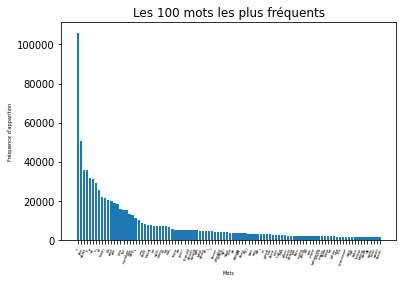

In [0]:
words = words_dict.keys()
values = train_df.values
nb_in_dict = 0
nb_not_in_dict = 0
size_max = 0
mean_size = 0
nb_examples = 100000
nb_of_ones = 0
print("Checking the proportion of words from the train set in the dictionary...")
dict_frequencies = {}
for value in values[:nb_examples]:
  if value[2] == 1: nb_of_ones += 1
  question = normalize_text(value[1], unusual_characters_list, dict_replace)
  list_of_words = question.split(" ")
  size = len(list_of_words) 
  mean_size += size
  if size > size_max: size_max = size
  for word in list_of_words:
    if len(word) != 0:
      if word in words:
        nb_in_dict += 1
      else:
        nb_not_in_dict +=1
      if word not in dict_frequencies.keys():
        dict_frequencies[word] = 1
      else:
        dict_frequencies[word] += 1
     
print("Number of words from the train set in the dictionary:", nb_in_dict)
print("Number of words from the train set not in the dictionary:", nb_not_in_dict)
print("Proportion of words inside the dictionary:", 
      nb_in_dict/(nb_in_dict + nb_not_in_dict))
print("Maximum size of the questions:", size_max)
print("Average size of the question:", mean_size/nb_examples)
print("Number of disposable questions:", nb_of_ones, "Percentage of ones:", 
      nb_of_ones/nb_examples)

list_words = []
list_frequencies = []
i = 1
for elem in sorted(dict_frequencies.items(), key = 
             lambda kv:(kv[1], kv[0]), reverse = True):
  list_words.append(elem[0])
  list_frequencies.append(elem[1])
  if i > 200:
    break
  i += 1
print(list_words)
index = np.arange(len(list_words[:100]))
plt.bar(list_words[:100], list_frequencies[:100])
plt.xlabel('Mots', fontsize=5)
plt.ylabel("Fréquence d'apparition", fontsize=5)
plt.xticks(index, list_words[:100], fontsize=4, rotation=70)
plt.title('Les 100 mots les plus fréquents')
plt.savefig("proportion", dpi = 400)
plt.show()


99% of the words contained in the train data set are in the dictionary which makes unecessary the use of a self-trained embedding layer. However, we have to know how to handle the "unknown" words, the OOV (Out Of Vocabulary). 

The maximum size of the questions is usually around 100 words, but the average is around 15.

Finally we only have 6% of ones (bad questions). 

Based on this information, there are several possibilities:
In order to train properly, we need to increase this percentage or we need to 

*   downsampling: extracting all the ones and some zeros to reach a 50/50 proportion.
*   oversampling: make copies of some ones to reach a 50/50 proportion.
*   cost-sensitive learning: set the loss so that it gives a greater importance to ones than to zeros.
*   don't change the proportion.

We chose to study two methods: **downsampling** and **not changing the proportion**. You can see both methods by commenting out the corresponding code below.

Remark: in both cases we extract only a part on the big training dataset which should have an impact on the final score.


In [0]:
# Modification of the train set to increase the proportion of ones

#train_set = []
#nb = 0
#for value in train_df.values:
#  if value[2] == 1:
#    train_set.append(value)
#    nb += 1
#  else:
#    if nb > 0:
#      train_set.append(value)
#      nb -= 1
#train_set = pd.DataFrame(train_set)
#train_df_bis, validate_df_bis = model_selection.train_test_split(train_set, test_size=0.1)
#print("New train set:", train_df_bis)
#print("New validation set:", validate_df_bis)

# If we don't want to reequilibrate the proportion:
unused_df, train_df_bis = model_selection.train_test_split(train_df, test_size=0.25)
del(unused_df)
train_df_bis, validate_df_bis = model_selection.train_test_split(train_df_bis, test_size=0.2)
print("New train set:", train_df_bis.shape)
print("New validation set:", validate_df_bis.shape)


New train set:                          qid  ... target
843386  a54990c28a3db2629032  ...      0
48745   098ba78bd5888c5d50d4  ...      0
709649  8aee206d441f3b23fb6f  ...      0
731442  8f3f3eaa5c1946e0a69c  ...      0
530540  67deae75d331af8d70ec  ...      0
...                      ...  ...    ...
422756  52ddd0540d937a29f2c0  ...      0
319786  3eac0cb76db5652b900d  ...      1
673285  83dc338cfb3dc1092e9c  ...      0
592745  74195a2e04c30651f5b9  ...      0
353124  45361a9475952a5ede50  ...      0

[235102 rows x 3 columns]
New validation set:                           qid  ... target
656282   808c9dcd10446bcb9b6d  ...      0
779414   98ae700637a9d6b74820  ...      0
553376   6c6d5ac4b0c3d1c738a6  ...      0
414991   5151b208697733125dc8  ...      0
32719    06678cfbd1af160b45e3  ...      0
...                       ...  ...    ...
850561   a6a8c3dafa8eaf533851  ...      0
1177724  e6c86e61d7b8897221e2  ...      0
436921   559e29acce0383fcec7b  ...      1
1032852  ca64b751a178414b4

## Out Of Vocabulary Handling

A good way to do that could be to attribute to this word an embedding depending on the embeddings of the neighbors. Let's imagine that we find this unknown word several times, it could be a great idea to recompute an embedding, the final embedding will then be the average of all the embeddings computed depending on the context, then we had this word to our dictionary.
Otherwise, we can just compute an average embedding for this sentence without using a new dictionary.

In [0]:
common_words_list = ["the", "a", "and", "for", "what", "that", "as", "but",
                     "if", "so", "of", "how", "is", "are",',', ';', ':', '!', 
                     '?', '.', '/', "'", '(', ')','[', ']', '{', '}', '~','"',
                     '’','”','‘','…', "-", "“", "^", '\\',]

# Computation of the contextual embedding:

def create_contextual_embedding(word_index, sentence, dictionary, common_words, 
                                nb_neighbors = 3):
  '''
  Computes the embedding vector for a word depending on the context.
  The context is defined by the number of neighbors in the sentence.
  If one of the words in the work list is not a part of dictionary.keys, 
  we ignore this word.

  INPUTS:
  - word_index: is the index of the word in the sentence.
  - sentence: is a list of string, each string is a word.
  - dictionary: is the dictionary associating embedding to each word.
  - common_words: list of usual words that we will not take into account because
  they might pollute our final embedding
  - nb_neighbors: is an int that defines the number of neighbors that we will 
  take into account to compute the output.
  OUTPUTS:
  - embedding_vector: is an array of size 300 corresponding to the estimated 
  embedding vector.
  RUNNING TIME: 
  Very short
  '''

  # Extraction of the work list:
  size = len(sentence)-1
  work_list = []
  if 2*nb_neighbors > size:
    if word_index < size:
      work_list = sentence[:word_index] + sentence[word_index+1:]
    else:
      work_list = sentence[:word_index]
  if word_index - nb_neighbors < 0:
    work_list = sentence[:word_index] + sentence[word_index+1:2*nb_neighbors + 1]
  else:
    if size >= word_index + nb_neighbors:
      work_list = sentence[word_index - nb_neighbors:word_index] + \
      sentence[word_index + 1: word_index + nb_neighbors +1 ]
    else:
      if word_index < size:
        work_list = sentence[size-2*nb_neighbors:word_index] + \
        sentence[word_index +1:]
      if word_index == size:
        work_list = sentence[-2*nb_neighbors-1:-1]

  # Extraction of the embeddings:
  embedding_list = []
  for word in work_list:
    if word in dictionary.keys() and word not in common_words:
      embedding_list.append(dictionary[word])
  embedding_list = np.array(embedding_list)

  # Computation of the unknown embedding:
  if len(embedding_list) != 0: 
    return np.mean(embedding_list, axis = 0, dtype = np.float32)
  else: return np.zeros(300, dtype=np.float32)
  
# # Test de create contextual embedding:

# maliste = ["What", "are", "some", "of", "the", "ways", "of", "earning", "money",
#            "online", "for", "a", "beginer"]
# embedding = create_contextual_embedding(7, maliste, words_dict, 
#                                         common_words_list, 2)
# print(embedding)


Creation of a new dictionary with the 1% unkown words:

In [0]:
# print("Computing the contextual embeddings for the OOV words...")
# new_dict = {}
# for value in values:
#   question = normalize_text(value[1], unusual_characters_list, dict_replace)
#   list_of_words = question.split(" ")
#   size = len(list_of_words)
#   for i in range(size):
#     word = list_of_words[i]
#     if word not in words:
#       if word not in new_dict.keys():
#         new_dict[word] = [create_contextual_embedding(i, list_of_words, 
#                                                       words_dict,
#                                                       common_words_list,2)]
#       else: new_dict[word] = new_dict[word] + \
#         [create_contextual_embedding(i, list_of_words, words_dict, 
#                                      common_words_list,2)]
# new_words = new_dict.keys()

# for new_word in new_words:
#   new_dict[new_word] = np.mean(np.array(new_dict[new_word], dtype=np.float32), 
#                                axis = 0, dtype = np.float16)
# print("Done.")

In [0]:
# # Displaying the embeddings for the first sentence containing an unknown word 
# encountered = False
# stop = False
# for value in values:
#   if stop: break
#   question = normalize_text(value[1], unusual_characters_list, dict_replace)
#   list_of_words = question.split(" ")
#   for word in list_of_words:
#     if word not in words:
#       encountered = True
#       print(list_of_words)
#   if encountered:
#     for word in list_of_words:
#       print(word)
#       if word in words:
#         print(words_dict[word])
#       else:
#         print("Unknown", new_dict[word])
#     stop = True
# for new_word in new_words:
#   print(new_word)
#   print(new_dict[new_word])
#   break         

## The RNN Networks

Now that we have our dictionary and that we have preprocessed our data, we can go into the heart of the problem: the network.

The difficulty of the training comes from the fact that we have to analyse sentences not words. 
Solutions: 


1.   Recurrent Neural Network 
2.   bag of words

Here we will study Recurrent Neural Networks.

In [0]:
class LSTM(nn.Module):

  def __init__(self, input_dim, hidden_dim, layer_dim=1, output_dim=1, dropout_rate=0.4):
    super(LSTM, self).__init__()
    # For bidirectional : multiply by 2 hidden_dim
    self.input_dim = input_dim
    self.hidden_dim_1 = hidden_dim
    self.hidden_dim_2 = int(hidden_dim/2)
    self.output_dim = output_dim
    self.layer_dim = layer_dim
    self.dropout = nn.Dropout(dropout_rate)
    self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, 
                        bidirectional = False)#True

    self.activation_1 = th.relu
    self.linear_1 = nn.Linear(self.hidden_dim_1, self.hidden_dim_2, bias = True)
    self.activation_2 = th.relu
    self.linear_2 = nn.Linear(self.hidden_dim_2, output_dim, bias = True)

  def init_hidden(self, input):
    return (th.zeros(self.layer_dim, input.size(0), self.hidden_dim_1),
            th.zeros(self.layer_dim, input.size(0), self.hidden_dim_1))

  def forward(self, input):
    h0 = self.init_hidden(input)
    lstm_out, hn = self.lstm(input, h0) # we modify self.hidden 
    # We take only the last value
    lstm_out = self.dropout(lstm_out[:,-1,:])
    lstm_out = self.activation_1(lstm_out)
    inter = self.linear_1(lstm_out)
    inter = self.dropout(inter)
    inter = self.activation_2(inter)
    out = self.linear_2(inter)#lstm_out[:, -1, :],lstm_out[:, 0, :]
    out = th.sigmoid(out)
    return out[:,0]

class RNN(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_rate = 0.4):
    super(RNN, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim_1 = hidden_dim
    self.hidden_dim_2 = int(hidden_dim/2)
    self.output_dim = output_dim
    self.layer_dim = layer_dim
    self.dropout = nn.Dropout(dropout_rate)

    self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, 
                      nonlinearity='relu', bidirectional = False) #True
    self.activation_1 = th.relu
    self.linear_1 = nn.Linear(self.hidden_dim_1, self.hidden_dim_2, bias = True)
    self.activation_2 = th.relu
    self.linear_2 = nn.Linear(self.hidden_dim_2, output_dim, bias = True)
    
  def forward(self, input):
    h0 = Variable(th.zeros(self.layer_dim, input.size(0), self.hidden_dim_1))
    # One time step
    rnn_out, hn = self.rnn(input, h0)
    # We take only the last value
    rnn_out = self.dropout(rnn_out[:,-1,:])
    rnn_out = self.activation_1(rnn_out)
    inter = self.linear_1(rnn_out)
    inter = self.dropout(inter)
    inter = self.activation_2(inter)
    out = self.linear_2(inter)
    out = th.sigmoid(out)
    return out[:,0]

class RNN_Conv(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, sentence_size,
               number_channels, conv_kernel, max_kernel, bidirectional=True,
               dropout_rate = 0.4):
    super(RNN_Conv, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim_1 = hidden_dim
    self.hidden_dim_2 = int(hidden_dim/2)
    self.output_dim = output_dim
    self.layer_dim = layer_dim
    self.dropout = nn.Dropout(dropout_rate)

    self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, 
                      nonlinearity='relu', bidirectional = bidirectional) #True
    self.conv = nn.Conv1d(in_channels = sentence_size, out_channels = number_channels,
                          kernel_size = conv_kernel, stride = 1, bias = True)
    i = (2 if bidirectional else 1)
    self.conv_output_size = i*hidden_dim - conv_kernel + 1 
    
    self.maxp = nn.MaxPool1d(kernel_size = max_kernel)
    self.maxp_output_size = number_channels * int(self.conv_output_size/max_kernel)

    self.flatten = nn.Flatten(start_dim = 1)
    self.activation_1 = th.relu
    self.linear_1 = nn.Linear(self.maxp_output_size, self.hidden_dim_2, bias = True)
    self.activation_2 = th.relu
    self.batch_norm = nn.BatchNorm1d(num_features = self.hidden_dim_2)
    self.linear_2 = nn.Linear(self.hidden_dim_2, output_dim, bias = True)
    
  def forward(self, input):
    h0 = Variable(th.zeros(self.layer_dim+1, input.size(0), self.hidden_dim_1))
    
    # RNN
    input = self.dropout(input)
    rnn_out, hn = self.rnn(input, h0)
    rnn_out = self.dropout(rnn_out)
    rnn_out = self.activation_1(rnn_out)
    
    # Conv
    conv_out = self.conv(rnn_out)
    conv_out = self.dropout(conv_out)
    conv_out = self.activation_1(conv_out)

    # Max
    conv_out = self.maxp(conv_out)

    # Flatten
    inter = self.flatten(conv_out)
    inter = self.linear_1(inter)
    inter = self.dropout(inter)
    # inter = self.batch_norm(inter)
    inter = self.activation_2(inter)
    out = self.linear_2(inter)
    out = th.sigmoid(out)
    return out[:,0]


In [0]:
def process_data(data, dictionary, nb_words_per_sentence, neighboring_area):
  '''
  Computes or extract the embedding for each sentence in the data set, after 
  this, the data can be put into the network directly.

  INPUTS:
  - data: is the data frame containing for each example : qid, string, target.
  - dictionary: is the dictionary associating embedding to each word.
  - nb_words_per_sentence: number of embeddings per sentences, if the sentence
  is longer, it takes the first nb_words_per_sentences embeddings
  - neighboring_area: int, size of the area to create contextual embeddings
  OUTPUTS:
  - trans_data: is an array of size data.shape[0], nb_words_per_sentences, 300 
  corresponding to the sentences in the embedding world.
  - trans_targets: same thing but containing the labels
  COMPUTATION TIME:
  proportional to data.shape[0], quite long.
  '''
  trans_data = []
  trans_targets = []
  a = 2
  for value in data:
    trans_value = []
    trans_target = []
    question = normalize_text(value[1], unusual_characters_list, dict_replace)
    list_of_words = question.split(" ")
    size = len(list_of_words)
    #limit the size of the sentence
    if size > nb_words_per_sentence:
      size = nb_words_per_sentence
    for i in range(size):
      word = list_of_words[i]
      if word not in words:
        trans_value += [create_contextual_embedding(i, list_of_words, 
                                                    dictionary,
                                                    common_words_list,
                                                    neighboring_area)]
      else: 
        if word.lower() in words:
          trans_value += [dictionary[word]]
        else: trans_value += [dictionary[word]]
    if size < nb_words_per_sentence:
      for i in range(nb_words_per_sentence - size):
        trans_value.append(np.zeros(300))      
    trans_data += [trans_value]
    trans_targets += [value[a]]
  trans_data = np.array(trans_data, dtype = np.float32)
  trans_targets = np.array(trans_targets)
  return trans_data, trans_targets   

In [0]:
def test_model(model, validate_df, words_dict, test_size, sentence_size, 
               neighboring_area, batch_size = 200):
  '''
  Computes the accuracy on a test set extracted from the validate_df with the 
  size given by test_size.

  INPUTS:
  - model: Net in pytorch.
  - validate_df: The whole validation dataframe (pandas).
  - words_dict: is the dictionary associating embedding to each word.
  - test_size: number of sentences that will be tested.
  - sentence_size: int, max size of a sentence
  - neighboring_area: int, size of the area used to create contextual embeddings 
  OUTPUTS:
  - avg acc: average accuracy of the model on the sample.
  - 0 acc: accuracy of the model on the 0 class.
  - 1 acc: accuracy of the model on the 1 class.
  - recall
  - precision
  - f1 score
  COMPUTATION TIME:
  proportional to test_size, quite long and cost in memory
  '''
  model.eval()
  sample = rd.sample(range(0, validate_df.shape[0]), test_size)
  val_df = [validate_df[i] for i in sample]

  size_of_batches = 5000
  const = int(2000/batch_size)
  print("Testing on {}...".format(test_size), end="", flush = True)

  ticks0 = time.time()

  nb_good, nb_good_zero, nb_good_one = 0, 0, 0
  nb_total, nb_zero, nb_one = 0, 0, 0
  nb_one_pred, nb_zero_pred = 0, 0

  for i in range(test_size//size_of_batches):
    features_test, targets_test = process_data(val_df[i*size_of_batches:(i+1)*size_of_batches],
                                              words_dict, sentence_size, 
                                              neighboring_area)
    features_test = th.from_numpy(features_test)
    targets_test = th.from_numpy(targets_test)

    test = th.utils.data.TensorDataset(features_test, targets_test)
    test_loader = th.utils.data.DataLoader(test, batch_size = batch_size, 
                                              shuffle = False)

    for i, (sentences, labels) in enumerate(test_loader):
      outputs = model(sentences)
      for i in range(outputs.shape[0]):
        output = outputs[i].item()
        label = labels[i].item()
        if label == 1:
          nb_one += 1
        else:
          nb_zero += 1

        if output > 0.5:
          output = 1
          nb_one_pred += 1
        else:
          output = 0
          nb_zero_pred += 1

        if output == label:
          nb_good += 1
          if output == 1:
            nb_good_one += 1
          else:
            nb_good_zero += 1
        nb_total += 1
  acc_avg = nb_good/nb_total
  acc_0 = nb_good_zero/nb_zero
  acc_1 = nb_good_one/nb_one
  recall = nb_good_one/(nb_good_one + nb_zero_pred - nb_good_zero)
  precision = nb_good_one/nb_one_pred
  ticks1 = time.time()
  print("Done. {:.2f}s".format(ticks1 - ticks0))
  print("acc avg: {:.3f}, acc 0: {:.3f}, acc 1: {:.3f}, recall: {:.3f},\
  precision: {:.3f}".format(acc_avg, acc_0, acc_1, recall, precision))
  f1_score = 2/(1/recall + 1/precision)
  print("F1 Score:", f1_score)
  return nb_good/nb_total, nb_good_zero/nb_zero, nb_good_one/nb_one, recall, precision, f1_score

### Training of RNN model

La fonction *train_model* est particulièrement complexe car elle doit prendre en compte le fait que toutes le train set avec pour chacune des quasi 200 000 phrases, une vingtaine de vecteurs de taille 300. Nous répartissons ainsi la charge de calcul:

In [0]:
def train_model(model, train, val, words_dict, loss, optimizer, sentence_size,
                neighboring_area, batch_size, num_epochs):
  '''
  Train the model on the train set.

  INPUTS:
  - model: Net in pytorch.
  - train: whole training dataframe (pandas)
  - val: The whole validation dataframe (pandas).
  - words_dict: is the dictionary associating embedding to each word.
  - loss: function respecting pytorch standards
  - optimizer: function respecting pytorch standards
  - sentence_size: int, size of the sequence
  - neighboring_area: int, size of the area to create contextual embeddings
  - batch_size: int, size of mini-batches
  - num_epochs: int, number of epochs
  OUTPUTS:
  - NONE
  COMPUTATION TIME:
  Extremely long and costly in RAM
  '''
  model.train()
  model.zero_grad()
  nb_train = train.shape[0]
  nb_val = val.shape[0]
  list_perfs = []
  size_of_batches = 10000
  coeff = int(nb_train/nb_val) + 1
  size_of_val_batches = int(size_of_batches/coeff)
  const = int(2000/batch_size)
  ticks0 = time.time()

  for epoch in range(num_epochs):
    ticks0 = time.time()
    print("Epoch :", epoch + 1)
    losses = []
    val_losses = []
    for k in range(nb_train//size_of_batches): 
      ticks1 = time.time()
      print("Preparing {} data...".format(size_of_batches), end="", flush=True)
      # if epoch == 0:
      #   features_train, targets_train = process_data(train.values[k*size_of_batches:(k+1)*size_of_batches], 
      #                                                words_dict, sentence_size,
      #                                                neighboring_area)
      #   np.save("features_{}.npy".format(k), features_train, allow_pickle=True)
      #   np.save("targets_{}.npy".format(k), targets_train, allow_pickle=True)
      # else:
      #   features_train = np.load("features_{}.npy".format(k), allow_pickle=True)
      #   targets_train = np.load("targets_{}.npy".format(k), allow_pickle=True)
      features_train, targets_train = process_data(train.values[k*size_of_batches:(k+1)*size_of_batches], 
                                                   words_dict, sentence_size,
                                                   neighboring_area)
      features_train = th.from_numpy(features_train)
      targets_train = th.from_numpy(targets_train)

      # if epoch == 0:
      #   features_test, targets_test = process_data(val.values[k*size_of_val_batches:(k+1)*size_of_val_batches], 
      #                                              words_dict, sentence_size,
      #                                              neighboring_area)
      #   np.save("features_val_{}.npy".format(k), features_train, allow_pickle=True)
      #   np.save("targets_val_{}.npy".format(k), targets_train, allow_pickle=True)
      # else:
      #   features_test = np.load("features_val_{}.npy".format(k), allow_pickle=True)
      #   targets_test = np.load("targets_val_{}.npy".format(k), allow_pickle=True)
      features_test, targets_test = process_data(val.values[k*size_of_val_batches:(k+1)*size_of_val_batches], 
                                                 words_dict, sentence_size,
                                                 neighboring_area)
      features_test = th.from_numpy(features_test)
      targets_test = th.from_numpy(targets_test)

      train_set = th.utils.data.TensorDataset(features_train, targets_train)
      test_set = th.utils.data.TensorDataset(features_test, targets_test)

      train_loader = th.utils.data.DataLoader(train_set, batch_size = batch_size, 
                                                shuffle = True)
      test_loader = th.utils.data.DataLoader(test_set, batch_size = size_of_val_batches, 
                                                shuffle = True)
      ticks2 = time.time()
      print("Done {:.2f}s.".format(ticks2-ticks1))
      print("Training...")
      for i, (sentences, labels) in enumerate(train_loader):
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(sentences)
        train_loss = loss(outputs, labels)
        losses += [train_loss.item()]
        train_loss.backward()
        optimizer.step()
        if (i%const == 0):
          test_sentences, test_labels = next(iter(test_loader))
          model.eval()
          test_labels = test_labels.float()
          outputs = model(test_sentences)
          test_loss = loss(outputs, test_labels)
          ticks3 = time.time()
          val_losses += [test_loss.item()]
          model.train()
          print("Training loss: {:.4f} | Validation loss: {:.4f} -- {} / {} in {:.2f}s".format(train_loss.item(),
                                                                                      test_loss.item(),
                                                                                      k*size_of_batches + (i+1)*batch_size,
                                                                                      nb_train,
                                                                                      ticks3-ticks1))
    ticks2 = time.time()
    nb = nb_train - (nb_train//size_of_batches)*size_of_batches
    print("Preparing {} data...".format(nb), end = "", flush = True)
    # if epoch == 0:
    #   features_train, targets_train = process_data(train.values[k*size_of_batches:(k+1)*size_of_batches], 
    #                                                words_dict, sentence_size,
    #                                                neighboring_area)
    #   np.save("features_{}.npy".format(k), features_train, allow_pickle=True)
    #   np.save("targets_{}.npy".format(k), targets_train, allow_pickle=True)
    # else:
    #   features_train = np.load("features_{}.npy".format(k), allow_pickle=True)
    #   targets_train = np.load("targets_{}.npy".format(k), allow_pickle=True)
    features_train, targets_train = process_data(train.values[k*size_of_batches:(k+1)*size_of_batches], 
                                                 words_dict, sentence_size,
                                                  neighboring_area)
    features_train = th.from_numpy(features_train)
    targets_train = th.from_numpy(targets_train)

    # if epoch == 0:
    #   features_test, targets_test = process_data(val.values[k*size_of_val_batches:(k+1)*size_of_val_batches], 
    #                                              words_dict, sentence_size,
    #                                              neighboring_area)
    #   np.save("features_val_{}.npy".format(k), features_train, allow_pickle=True)
    #   np.save("targets_val_{}.npy".format(k), targets_train, allow_pickle=True)
    # else:
    #   features_test = np.load("features_val_{}.npy".format(k), allow_pickle=True)
    #   targets_test = np.load("targets_val_{}.npy".format(k), allow_pickle=True)
    features_test, targets_test = process_data(val.values[k*size_of_val_batches:(k+1)*size_of_val_batches], 
                                               words_dict, sentence_size,
                                               neighboring_area)
    features_test = th.from_numpy(features_test)
    targets_test = th.from_numpy(targets_test)

    train_set = th.utils.data.TensorDataset(features_train, targets_train)
    test_set = th.utils.data.TensorDataset(features_test, targets_test)

    train_loader = th.utils.data.DataLoader(train_set, batch_size = batch_size, 
                                               shuffle = True)
    test_loader = th.utils.data.DataLoader(test_set, batch_size = size_of_val_batches, 
                                              shuffle = True)
    ticks3 = time.time()
    print("Done {:.2f}s.".format(ticks3-ticks2))
    print("Training...", end="", flush=True)
    for i, (sentences, labels) in enumerate(train_loader):
        labels = labels.float()
        optimizer.zero_grad()
        outputs = model(sentences)
        train_loss = loss(outputs, labels)
        losses += [train_loss.item()]
        train_loss.backward()
        optimizer.step()
    ticks3 = time.time()
    print("Done.")
    print("Epoch n°{}: TRAIN LOSS {:.4f} | VAL LOSS {:.4f} TOTAL TIME: {:.2f}s.".format(epoch+1, 
                                                                        sum(losses)/len(losses),
                                                                        sum(val_losses)/len(val_losses),
                                                                        ticks3-ticks0))
    model.eval()
    perfs = test_model(model, validate_df.values, words_dict, 10000, sentence_size, 
               neighboring_area)
    th.save(model.state_dict(), "/content/epoch_{}.pt".format(epoch+1))
    list_perfs.append(perfs[-1])
    model.train()
    print("______________________________________________________________________")
    del(features_train)
    del(targets_train)
    del(features_test)
    del(targets_test)
    del(train_set)
    del(test_set)
    del(train_loader)
    del(test_loader)
    del(losses)
  # we load the model with the best performances
  index_best = np.argmax(np.array(list_perfs))
  print("Loading model with best performances: epoch {}".format(index_best+1))
  model = th.load("/content/epoch_{}.pt".format(index_best+1))
  return None

In [0]:
# Connect your personnal drive to save the model generated:
# drive.mount('/content/drive')
# Change this line to adapt it to your drive
# path = "/content/drive/My Drive/Cours/Kaggle/"

#Hyperparameters:
sentence_size = 30
neighboring_area = 3

# Create RNN
input_dim = 300   
hidden_dim = 400 
layer_dim = 1    
output_dim = 1 
number_channels = 16
conv_kernel = 3
max_kernel = 4
dropout_rate = 0.4 

# model = RNN(input_dim, hidden_dim, layer_dim, output_dim)
# model = LSTM(input_dim, hidden_dim, layer_dim, output_dim)
model = RNN_Conv(input_dim, hidden_dim, layer_dim, output_dim, sentence_size, 
                 number_channels, conv_kernel, max_kernel, dropout_rate=dropout_rate)
# print(model)

# Training Parameters
batch_size = 200
num_epochs = 10
learning_rate = 0.00005
loss = nn.BCELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = th.optim.Adam(model.parameters(), lr=learning_rate, 
                          betas=(0.9, 0.999), eps=1e-08, 
                          weight_decay=0.0001, amsgrad=False)

# Training on train bis:
train_model(model, train_df_bis, validate_df_bis, words_dict, loss, optimizer, 
            sentence_size, neighboring_area, batch_size, num_epochs)

# Saving
# th.save(model.state_dict(), path+'model_RNNConv_U.pt') #Epochs 20

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch : 1
Preparing 10000 data...Done 2.88s.
Training...
Training loss: 0.6762 | Validation loss: 0.6589 -- 200 / 235102 in 4.54s
Training loss: 0.4339 | Validation loss: 0.5029 -- 2200 / 235102 in 9.40s
Training loss: 0.2860 | Validation loss: 0.3782 -- 4200 / 235102 in 14.15s
Training loss: 0.3066 | Validation loss: 0.2968 -- 6200 / 235102 in 18.81s
Training loss: 0.2172 | Validation loss: 0.2736 -- 8200 / 235102 in 23.58s
Preparing 10000 data...Done 2.97s.
Training...
Training loss: 0.2349 | Validation loss: 0.2912 -- 10200 / 235102 in 4.67s
Training loss: 0.2188 | Validation loss: 0.3056 -- 12200 / 235102 in 9.31s
Training loss: 0.2522 | Validation loss: 0.2987 -- 14200 / 235102 in 13.86s
Training loss: 0.2586 | Validation loss: 0.2883 -- 16200 / 235102 in 18.49s
Training loss: 0.2599 | Validation loss: 0.2895 -- 18200 / 235102 in 23.14s
Preparing 10000 d

### Test of the model
We test on validate_df which is in fact a test set, with a normal proportion of 0 and 1 (about 6% of 1).

In [0]:
#model = RNN_Conv(input_dim, hidden_dim, layer_dim, output_dim, sentence_size, 
#                 number_channels, conv_kernel, max_kernel, dropout_rate=dropout_rate)
#model.load_state_dict(th.load(path+'model_RNNConv_U.pt'))
model.eval()
#model = th.load(path + 'model6.pt')
#model.eval()
print(model)
print(test_model(model, validate_df.values, words_dict, 50000, sentence_size, neighboring_area))

RNN_Conv(
  (dropout): Dropout(p=0.4, inplace=False)
  (rnn): RNN(300, 400, batch_first=True, bidirectional=True)
  (conv): Conv1d(30, 16, kernel_size=(3,), stride=(1,))
  (maxp): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten()
  (linear_1): Linear(in_features=3184, out_features=200, bias=True)
  (batch_norm): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_2): Linear(in_features=200, out_features=1, bias=True)
)
Testing on 50000...Done. 58.21s
acc avg: 0.956, acc 0: 0.981, acc 1: 0.567, recall: 0.567,  precision: 0.661
F1 Score: 0.6101574942488055
(0.95594, 0.9811533710975766, 0.5667324128862591, 0.5667324128862591, 0.6607895745496358, 0.6101574942488055)


## BERT finetuning

In this part, we will fine-tune a model imported from Hugging's Face Library. 

In [0]:
!pip install transformers

     |████████████████████████████████| 645kB 2.8MB/s 
     |████████████████████████████████| 3.8MB 13.0MB/s 
     |████████████████████████████████| 1.0MB 41.6MB/s 
     |████████████████████████████████| 890kB 48.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=ec9cc05237dbd6d8b2aaa300b71bfa19f4e501cb529c0142329b3fa3b060bf1d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
from sklearn.metrics import accuracy_score, f1_score
import os
import tqdm
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset # used load data
import torch.optim as optim

from transformers.data.processors.utils import InputExample, InputFeatures
from transformers import (AdamW,
                          get_linear_schedule_with_warmup,
                          get_cosine_with_hard_restarts_schedule_with_warmup)
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig

# Functions to process data

class InputExample(object):

  def __init__(self, guid, text_a, text_b=None, label=None):
    """ 
    INPUTS:
    - guid: string, describing the example
    - text_a: string, text of the example
    - text_b: string, optional
    - label: int, optional
    """
    self.guid = guid
    self.text_a = text_a
    self.text_b = text_b
    self.label = label

    
class DataProcessor():
    
  def get_data_examples(self, sentences, labels=None):
    """
    This function transforms a list of sentences into a list of 
    InputExample.
    """
    examples = []
    guid = "data"
    if labels is None:
      for i in range(len(sentences)):
        examples.append(InputExample(guid=guid, text_a=sentences[i], text_b=None, label="0"))
    else:
      for i in range(len(sentences)):
        examples.append(InputExample(guid=guid, text_a=sentences[i], text_b=None, label=str(labels[i])))
        
    return examples

  def get_labels(self):
    """See base class."""
    return [str(j) for j in range(2)]

    
def convert_examples_to_features(examples, tokenizer, max_length=50, label_list=None,
                                 pad_token=0, pad_token_segment_id=0,
                                 mask_padding_with_zero=True):
  """
  This function encodes string sentences using the tokenizer applying max_length,
  padding and mask.
  INPUTS:
  - examples: list of InputExample objects, examples to tokenize.
  - tokenizer: tokenizer object.
  - max_length: int, max_length of sequences.
  - label_list: list of all possible labels.
  - pad_token: int, default token for padding.
  - pad_token_segment_id: int, default id for padding.
  - mask_padding_with_zero: bool, saying if we mask padding with zero or 1.
  OUTPUTS:
  - features: list of InputFeatures object.
  """
  processor = DataProcessor()

  label_map = {label: i for i, label in enumerate(label_list)}

  features = []
  for (ex_index, example) in enumerate(examples):

    inputs = tokenizer.encode_plus(example.text_a, example.text_b,
                                    add_special_tokens=True,
                                    max_length=max_length)
    input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding_length = max_length - len(input_ids)
    input_ids = input_ids + ([pad_token] * padding_length)
    attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
    token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)

    assert len(input_ids) == max_length, "Error with input length {} vs {}".format(len(input_ids), max_length)
    assert len(attention_mask) == max_length, "Error with input length {} vs {}".format(len(attention_mask), max_length)
    assert len(token_type_ids) == max_length, "Error with input length {} vs {}".format(len(token_type_ids), max_length)
    
    label = label_map[example.label]
    
    features.append(InputFeatures(input_ids=input_ids, attention_mask=attention_mask,
                                  token_type_ids=token_type_ids, label=label))

  return features

def load_examples(sentences, labels, tokenizer, max_seq_length, label_list):
  """
  This function converts a group of sentences and labels into a proper 
  TensorDataset using the tokenizer.
  INPUTS:
  - sentences: pandas dataframe, sentences that we want to analyze.
  - labels: pandas dataframe, labels of sentences
  - tokenizer: tokenizer object
  - max_seq_length: int, max length of a sentence.
  - label_list: list of strings, reprensenting all the different labels.
  OUTPUTS:
  - dataset: TensorDataset torch, organized dataset for training and testing.
  """
  processor = DataProcessor()
  examples = processor.get_data_examples(sentences, labels)

  features = convert_examples_to_features(examples, tokenizer, max_length=max_seq_length,
                                          label_list = label_list,
                                          pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                          pad_token_segment_id=0)

  # Convert to Tensors and build dataset
  all_input_ids = th.tensor([f.input_ids for f in features], dtype=th.long)
  all_attention_mask = th.tensor([f.attention_mask for f in features], dtype=th.long)
  all_token_type_ids = th.tensor([f.token_type_ids for f in features], dtype=th.long)
  all_labels = th.tensor([f.label for f in features], dtype=th.long)

  dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
  return dataset

### Training BERT

In [0]:
def evaluate(model, eval_dataset, tokenizer, eval_batch_size=8):
  """
  This function evaluates the performance of the model on the eval dataset.
  INPUTS:
  - model: Torch model, model to evaluate
  - eval_datastet: Torch Dataset, evaluation set
  - tokenizer: tokenizer object
  - eval_batch_size: int, size of batch size for evaluation.
  OUTPUTS:
  - result: dictionary, contains loss, accuracy and f1_score
  """      
  eval_batch_size = eval_batch_size
  eval_sampler = SequentialSampler(eval_dataset)
  eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)
  
  t0 = time.time()
  print("Running evaluation...", end= '', flush=True)
      
  eval_loss = 0.0
  nb_eval_steps = 0
  out_label_ids = None
  iterator = eval_dataloader
  
  preds = None

  for batch in iterator:
    model.eval()
    batch = tuple(t.to(device) for t in batch)

    with th.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'labels':         batch[3]}
      inputs['token_type_ids'] = batch[2] #or None
      outputs = model(**inputs)
      tmp_eval_loss, logits = outputs[:2]
      eval_loss += tmp_eval_loss.mean().item()
    nb_eval_steps += 1
    if preds is None:
      preds = logits.detach().cpu().numpy()
      out_label_ids = inputs['labels'].detach().cpu().numpy()
    else:
      preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
      out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

  eval_loss = eval_loss / nb_eval_steps
  preds_class = np.argmax(preds, axis=1)
  # print(out_label_ids)
  # print(preds_class)
  acc = accuracy_score(out_label_ids, preds_class)
  f1 = f1_score(out_label_ids, preds_class)
  
  result = {"val_loss": eval_loss, "val_acc" : acc, "f1": f1}
  t1 = time.time()
  print("Done. {:.2f}".format(t1-t0))
  return result

def train_BERT_model(model, train, val, test, tokenizer, learning_rate, 
                     batch_size, num_epochs, warmup_steps=0, num_cycles=1.0,
                     gradient_accumulation_steps=1):
  '''
  Train the model on the train set.

  INPUTS:
  - model: Net in pytorch.
  - train: whole training dataframe (pandas)
  - val: The whole validation dataframe (pandas).
  - test: pandas dataframe, test dataset
  - tokenizer: tokenizer object, pretrained
  - learning_rate: float, learning rate
  - batch_size: int, size of mini-batches
  - num_epochs: int, number of epochs
  - warmup_steps: int, parameter of AdamW
  - num_cycles: float, parameter of AdamW
  OUTPUTS:
  - NONE
  COMPUTATION TIME:
  Extremely long and costly in RAM
  '''
  model.train()
  model.zero_grad()
  list_perfs = []

  train_sampler = RandomSampler(train)
  train_dataloader = DataLoader(train, sampler=train_sampler, batch_size=batch_size)

  t_total = len(train_dataloader) // gradient_accumulation_steps * num_epochs

  optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
  scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer,
                                                                 num_warmup_steps=warmup_steps,
                                                                 num_training_steps=t_total,
                                                                 num_cycles=num_cycles)

  for epoch in range(num_epochs):
    ticks0 = time.time()
    print("Epoch :", epoch + 1)
    losses = []
    val_losses = []
    epoch_iterator = train_dataloader
    for step, batch in enumerate(epoch_iterator): 
      model.train()
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'labels':         batch[3]}
      inputs['token_type_ids'] = batch[2] 
      optimizer.zero_grad()

      outputs = model(**inputs)
      loss = outputs[0]  
      losses.append(loss.item())
      loss.backward()

      optimizer.step()
      scheduler.step()  # Update learning rate schedule
      model.zero_grad()
      if step%10 == 0:
        print("Lr: {:.6f}".format(scheduler.get_lr()[0]), " | Train Loss: {:.4f}", loss.item())

      if step%100 == 0 : #and step > 0
        model.eval()
        results = evaluate(model=model, eval_dataset=val, tokenizer=tokenizer)
        val_losses += [results["val_loss"]]
        model.train()
        print("Lr: {:.6f} | Train loss: {:.4f} | Val loss: {:.4f}, Val acc: {:.4f} | {}".format(scheduler.get_lr()[0],
                                                                                       loss.item(),
                                                                                       results["val_loss"], 
                                                                                       results["val_acc"],
                                                                                       step*batch_size))

    ticks3 = time.time()
    print("Done.")
    print("Epoch n°{}: TRAIN LOSS {:.4f} | VAL LOSS {:.4f} | TOTAL TIME: {:.2f}s.".format(epoch+1, 
                                                                        sum(losses)/len(losses),
                                                                        sum(val_losses)/len(val_losses),
                                                                        ticks3-ticks0))
    model.eval()
    results = evaluate(model=model, eval_dataset=test, tokenizer=tokenizer)
    th.save(model.state_dict(), "/content/epoch_{}.pt".format(epoch+1))
    list_perfs.append(results["f1"])
    print("F1 score: {:.4f}".format(results["f1"]))
    model.train()
    print("______________________________________________________________________")
  index_best = np.argmax(np.array(list_perfs))
  print("Loading model with best performances: epoch {}".format(index_best+1))
  model = th.load("/content/epoch_{}.pt".format(index_best+1))
  return None

In [0]:
print(validate_df)
print(validate_df_bis)

                          qid  ... target
738975   90b952c8cf6e77763868  ...      0
616701   78c48243c367915c6071  ...      0
893661   af185eb18ed4da49b8bc  ...      1
872857   ab036f055ee94694d16c  ...      0
25791    050ed8ac80d55a03b15a  ...      0
...                       ...  ...    ...
1081783  d3fdfb65b0da453858da  ...      0
1075448  d2bc3b3a2112f57efa99  ...      0
1020524  c7fb6feff7eda31015f7  ...      0
1252564  f5765e8a05893e5e5eba  ...      1
339675   428b9d0d5562f9e2633f  ...      0

[130613 rows x 3 columns]
                          qid  ... target
656282   808c9dcd10446bcb9b6d  ...      0
779414   98ae700637a9d6b74820  ...      0
553376   6c6d5ac4b0c3d1c738a6  ...      0
414991   5151b208697733125dc8  ...      0
32719    06678cfbd1af160b45e3  ...      0
...                       ...  ...    ...
850561   a6a8c3dafa8eaf533851  ...      0
1177724  e6c86e61d7b8897221e2  ...      0
436921   559e29acce0383fcec7b  ...      1
1032852  ca64b751a178414b447a  ...      0
287700 

In [0]:
sentence_size = 30
nb_labels = 2
learning_rate = 3e-5

batch_size = 200
num_epochs = 2
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# input_ids = th.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
# labels = th.tensor([1]).unsqueeze(0)  # Batch size 1
# outputs = model(input_ids, labels=labels)

# loss, logits = outputs[:2]
try:
  sentences_tr = train_df_bis[1].values
  labels_tr = train_df_bis[2].values
  sentences_val = validate_df_bis[1].values
  labels_val = validate_df_bis[2].values
except:
  sentences_tr = train_df_bis["question_text"].values
  labels_tr = train_df_bis["target"].values
  sentences_val = validate_df_bis["question_text"].values
  labels_val = validate_df_bis["target"].values
  pass
sentences_test = validate_df["question_text"].values
labels_test = validate_df["target"].values

dataset_tr = load_examples(sentences=sentences_tr, labels=labels_tr,
                            tokenizer=tokenizer, max_seq_length = sentence_size,
                            label_list = [str(j) for j in range(nb_labels)])

dataset_val = load_examples(sentences=sentences_val, labels=labels_val,
                            tokenizer=tokenizer, max_seq_length = sentence_size,
                            label_list = [str(j) for j in range(nb_labels)])

dataset_test = load_examples(sentences=sentences_test, labels=labels_test,
                            tokenizer=tokenizer, max_seq_length = sentence_size,
                            label_list = [str(j) for j in range(nb_labels)])

In [0]:
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=2, 
                                      finetuning_task='classification')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                      config=config)
model = model.to(device)
train_BERT_model(model, dataset_tr, dataset_val, dataset_test, tokenizer,
                 learning_rate, batch_size, num_epochs)
#path = "/content/drive/My Drive/Cours/Kaggle/"
#th.save(model.state_dict(), path+'modelBERT.pt')


Epoch : 1
Lr: 2.9999994052919367e-05  | Train Loss: 0.9654431939125061
Running evaluation...

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Done. 321.87
Lr: 2.9999994052919367e-05 | Train loss: 0.9654 | Val loss: 0.6866, Val acc: 0.5330 | 0
Lr: 2.9999280408948928e-05  | Train Loss: 0.3273201286792755
Lr: 2.99973774136912e-05  | Train Loss: 0.23106227815151215
Lr: 2.9994285218042063e-05  | Train Loss: 0.10356522351503372
Lr: 2.9990004067193748e-05  | Train Loss: 0.20537562668323517
Lr: 2.9984534300615354e-05  | Train Loss: 0.11596480011940002
Lr: 2.9977876352025952e-05  | Train Loss: 0.1523970365524292
Lr: 2.997003074936018e-05  | Train Loss: 0.1660945564508438
Lr: 2.9960998114726396e-05  | Train Loss: 0.07099092751741409
Lr: 2.9950779164357328e-05  | Train Loss: 0.11807925254106522
Lr: 2.99393747085533e-05  | Train Loss: 0.1300225704908371
Running evaluation...Done. 324.04
Lr: 2.99393747085533e-05 | Train loss: 0.1300 | Val loss: 0.1247, Val acc: 0.9462 | 20000
Lr: 2.9926785651617986e-05  | Train Loss: 0.18724480271339417
Lr: 2.9913012991786666e-05  | Train Loss: 0.17069974541664124
Lr: 2.9898057821147116e-05  | Train Loss

KeyboardInterrupt: ignored

### Testing BERT

In [0]:
model.load_state_dict(th.load('epoch_1.pt'))
model.eval()
results = evaluate(model=model, eval_dataset=dataset_test, tokenizer=tokenizer)
print(results)

Running evaluation...Done. 711.63
{'val_loss': 0.09551778247697096, 'val_acc': 0.9617419399294098, 'f1': 0.6590242238143977}


In [0]:
model.load_state_dict(th.load('epoch_2.pt'))
model.eval()
results = evaluate(model=model, eval_dataset=dataset_test, tokenizer=tokenizer)
print(results)

Running evaluation...Done. 709.14
{'val_loss': 0.09709692623692368, 'val_acc': 0.9615275661687581, 'f1': 0.6772017729813067}
